# Enhanced Image Analysis Techniques Using Multiscale Feature Extraction and Attention Mechanisms

**Achraf Kamni** (A20509594)  
**Sakher Yaish** (A20496906)  

**November 10, 2024**  
**CS 512 - Fall 2024**


## Imports

In [1]:
!pip install datasets

# TensorFlow & Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Datasets & Image handling
import datasets
from datasets import load_dataset
from PIL import Image
import io

# Data manipulation & metrics
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, fbeta_score, classification_report, precision_score,
    recall_score, accuracy_score, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize

# Visualization
import matplotlib
import matplotlib.pyplot as plt


In [2]:
# Creating a dictionary of package names and their versions
package_versions = {
    "tensorflow": tf.__version__,
    "torch": torch.__version__,
    "datasets": datasets.__version__,
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "sklearn": sklearn.__version__,
    "matplotlib": matplotlib.__version__,
    "PIL": Image.__version__
}

requirements_text = "\n".join(f"{pkg}=={version}" for pkg, version in package_versions.items())
file_path = "/content/requirements.txt"
with open(file_path, "w") as file:
    file.write(requirements_text)

print(f"Requirements file created at: {file_path}")


Requirements file created at: /content/requirements.txt


## Loading and exploring the data

In [3]:
dataset = load_dataset("pain/ArASL_Database_Grayscale")
train_df = dataset["train"].to_pandas()

train_data, temp_data = train_test_split(train_df, test_size=0.4, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

labels = dataset["train"].features["label"].names
label_mapping = {i: label for i, label in enumerate(labels)}
num_classes = len(label_mapping)

# Print the number of samples in each split
print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(val_data)}")
print(f"Number of test samples: {len(test_data)}")

# unique labels and create a mapping if the labels are ClassLabels
if isinstance(dataset["train"].features["label"], datasets.ClassLabel):
    labels = dataset["train"].features["label"].names
    label_mapping = {i: label for i, label in enumerate(labels)}
    print("Label mapping:", label_mapping)
else:
    print("Label column is not a ClassLabel. Please check the dataset structure.")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Number of training samples: 32429
Number of validation samples: 10810
Number of test samples: 10810
Label mapping: {0: 'ain', 1: 'al', 2: 'aleff', 3: 'bb', 4: 'dal', 5: 'dha', 6: 'dhad', 7: 'fa', 8: 'gaaf', 9: 'ghain', 10: 'ha', 11: 'haa', 12: 'jeem', 13: 'kaaf', 14: 'khaa', 15: 'la', 16: 'laam', 17: 'meem', 18: 'nun', 19: 'ra', 20: 'saad', 21: 'seen', 22: 'sheen', 23: 'ta', 24: 'taa', 25: 'thaa', 26: 'thal', 27: 'toot', 28: 'waw', 29: 'ya', 30: 'yaa', 31: 'zay'}



Training Samples:
Label: al


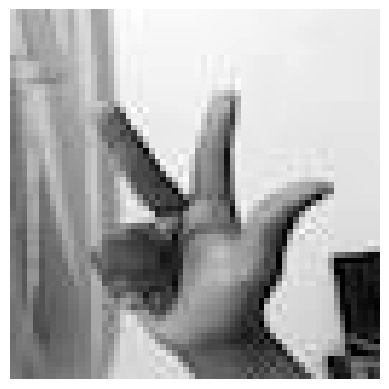


Validation Samples:
Label: zay


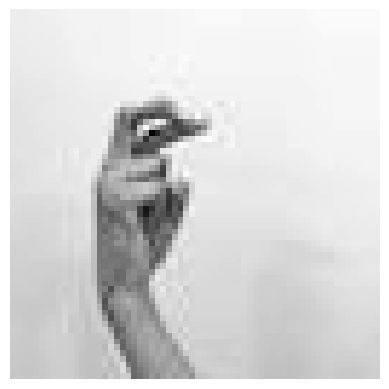


Test Samples:
Label: bb


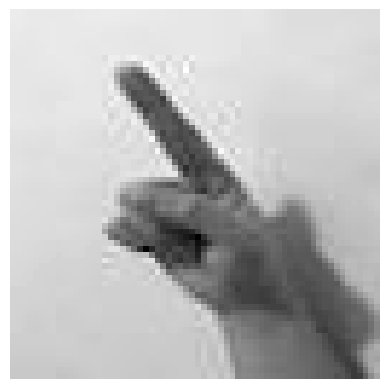

In [4]:
def display_sample(dataframe, num_samples=2):
    for i in range(num_samples):
        sample = dataframe.iloc[i]
        image = Image.open(io.BytesIO(sample['image']['bytes']))
        label_id = sample['label']
        label_name = label_mapping.get(label_id, "Unknown")
        print(f"Label: {label_name}")
        image = image.convert('L')
        image_array = np.array(image)
        plt.imshow(image_array, cmap='gray')
        plt.axis('off')
        plt.show()

print("\nTraining Samples:")
display_sample(train_data, num_samples=1)

print("\nValidation Samples:")
display_sample(val_data, num_samples=1)

print("\nTest Samples:")
display_sample(test_data, num_samples=1)


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, label_mapping, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.label_mapping = label_mapping
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_bytes = self.dataframe.iloc[idx]["image"]["bytes"]
        image = Image.open(io.BytesIO(img_bytes)).convert("L")
        if self.transform:
            image = self.transform(image)
        label = self.dataframe.iloc[idx]["label"]
        label = torch.tensor(label, dtype=torch.long)
        return image, label

train_dataset = CustomImageDataset(train_data, label_mapping, transform=transform)
val_dataset = CustomImageDataset(val_data, label_mapping, transform=transform)
test_dataset = CustomImageDataset(test_data, label_mapping, transform=transform)

# data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [6]:
import tensorflow as tf

def dataloader_to_tf_dataset(dataloader):
    def generator():
        for images, labels in dataloader:
            images_np = images.numpy().transpose(0, 2, 3, 1)
            labels_np = labels.numpy()
            for i in range(len(images_np)):
                yield images_np[i], labels_np[i]

    output_signature = (
        tf.TensorSpec(shape=(224, 224, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    return tf.data.Dataset.from_generator(generator, output_signature=output_signature)

train_tf_dataset = dataloader_to_tf_dataset(train_loader).batch(32)
val_tf_dataset = dataloader_to_tf_dataset(val_loader).batch(32)
test_tf_dataset = dataloader_to_tf_dataset(test_loader).batch(32)



In [7]:
for images, labels in train_tf_dataset.take(1):
    print(f'Train batch images shape: {images.shape}, Labels shape: {labels.shape}')

for images, labels in val_tf_dataset.take(1):
    print(f'Validation batch images shape: {images.shape}, Labels shape: {labels.shape}')

for images, labels in test_tf_dataset.take(1):
    print(f'Test batch images shape: {images.shape}, Labels shape: {labels.shape}')

Train batch images shape: (32, 224, 224, 1), Labels shape: (32,)
Validation batch images shape: (32, 224, 224, 1), Labels shape: (32,)
Test batch images shape: (32, 224, 224, 1), Labels shape: (32,)


## Training a basic U-Net model

In [8]:
def unet_classification_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    x = layers.GlobalAveragePooling2D()(c5)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=[inputs], outputs=[outputs])
    return model

input_shape = (224, 224, 1)
num_classes = 32

model = unet_classification_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [9]:
history = model.fit(
    train_tf_dataset,
    validation_data=val_tf_dataset,
    epochs=10,
    verbose=1
)

model.save("/content/simple_unet.keras")

Epoch 1/10
   1014/Unknown 41s 28ms/step - accuracy: 0.0367 - loss: 3.4638

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1014/1014 ━━━━━━━━━━━━━━━━━━━━ 54s 41ms/step - accuracy: 0.0367 - loss: 3.4638 - val_accuracy: 0.0395 - val_loss: 3.4605
Epoch 2/10
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 30s 29ms/step - accuracy: 0.0396 - loss: 3.4594 - val_accuracy: 0.0348 - val_loss: 3.4608
Epoch 3/10
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 30s 29ms/step - accuracy: 0.0379 - loss: 3.4603 - val_accuracy: 0.0395 - val_loss: 3.4605
Epoch 4/10
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 30s 29ms/step - accuracy: 0.0392 - loss: 3.4601 - val_accuracy: 0.0395 - val_loss: 3.4605
Epoch 5/10
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 30s 29ms/step - accuracy: 0.0380 - loss: 3.4599 - val_accuracy: 0.0395 - val_loss: 3.4603
Epoch 6/10
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 30s 29ms/step - accuracy: 0.0365 - loss: 3.4609 - val_accuracy: 0.0395 - val_loss: 3.4603
Epoch 7/10
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 30s 29ms/step - accuracy: 0.0395 - loss: 3.4603 - val_accuracy: 0.0348 - val_loss: 3.4603
Epoch 8/10
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 30s 29ms/step - accuracy: 0.0392 - loss: 3.46

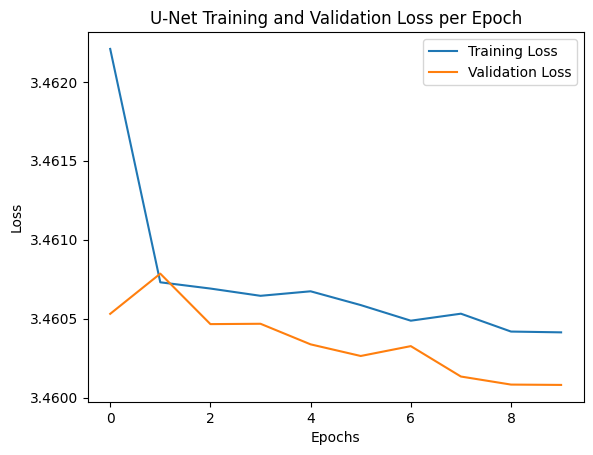

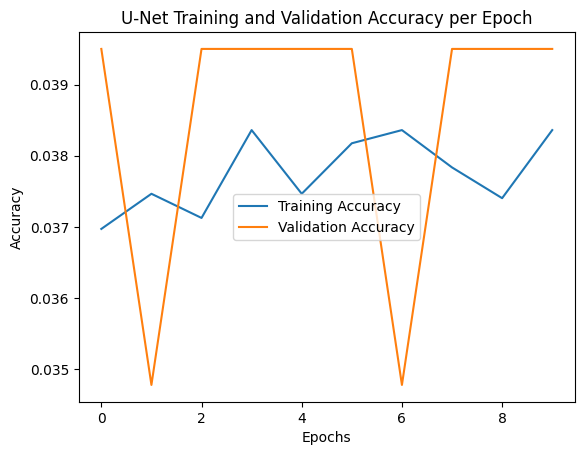

In [10]:
history_dict = history.history

plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('U-Net Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('U-Net Training and Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [11]:
test_loss, test_accuracy = model.evaluate(test_tf_dataset, verbose=1)

# True and predicted labels for calculating metrics
y_true = []
y_pred = []

for images, labels in test_tf_dataset:
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(model.predict(images, verbose=0), axis=-1))

# Calculate metrics
f1 = f1_score(y_true, y_pred, average='macro')
f2 = fbeta_score(y_true, y_pred, average='macro', beta=2)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

# Calculate AUC for multi-class using one-vs-all approach
y_true_binarized = label_binarize(y_true, classes=range(num_classes))
y_pred_probs = model.predict(test_tf_dataset, verbose=0)
auc_score = roc_auc_score(y_true_binarized, y_pred_probs, average='macro', multi_class='ovr')

# Print the metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f'F1 Score (Macro Average): {f1:.4f}')
print(f'F2 Score (Macro Average): {f2:.4f}')
print(f'Precision (Macro Average): {precision:.4f}')
print(f'Recall (Macro Average): {recall:.4f}')
print(f'AUC (Macro Average): {auc_score:.4f}')

# Calculate and store ROC curve data for future plotting
simple_unet_auc = []

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    simple_unet_auc.append({
        "class": i,
        "fpr": fpr,
        "tpr": tpr,
        "auc": roc_auc
    })

338/338 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.0393 - loss: 3.4608


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Test Accuracy: 0.0410
Test Loss: 3.4595
F1 Score (Macro Average): 0.0025
F2 Score (Macro Average): 0.0055
Precision (Macro Average): 0.0013
Recall (Macro Average): 0.0312
AUC (Macro Average): 0.5000


## Finetuining Resnet50

In [12]:
dataset = datasets.load_dataset("pain/ArASL_Database_Grayscale")

train_df = dataset["train"].to_pandas()

train_data, temp_data = train_test_split(train_df, test_size=0.4, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

labels = dataset["train"].features["label"].names
label_mapping = {i: label for i, label in enumerate(labels)}
num_classes = len(label_mapping)


In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
])

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, label_mapping, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.label_mapping = label_mapping
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_bytes = self.dataframe.iloc[idx]["image"]["bytes"]
        image = Image.open(io.BytesIO(img_bytes)).convert("L")
        if self.transform:
            image = self.transform(image)
        label = self.dataframe.iloc[idx]["label"]
        label = torch.tensor(label, dtype=torch.long)
        return image, label

train_dataset = CustomImageDataset(train_data, label_mapping, transform=transform)
val_dataset = CustomImageDataset(val_data, label_mapping, transform=transform)
test_dataset = CustomImageDataset(test_data, label_mapping, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [14]:
def dataloader_to_tf_dataset(dataloader):
    def generator():
        for images, labels in dataloader:
            images_np = images.numpy().transpose(0, 2, 3, 1)
            labels_np = labels.numpy()
            for i in range(len(images_np)):
                yield images_np[i], labels_np[i]

    output_signature = (
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    return tf.data.Dataset.from_generator(generator, output_signature=output_signature)

train_tf_dataset = dataloader_to_tf_dataset(train_loader).batch(32)
val_tf_dataset = dataloader_to_tf_dataset(val_loader).batch(32)
test_tf_dataset = dataloader_to_tf_dataset(test_loader).batch(32)

In [15]:
def create_resnet_model(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(
        include_top=False, weights="imagenet", input_shape=input_shape
    )
    base_model.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

input_shape = (224, 224, 3)
model = create_resnet_model(input_shape, num_classes)

In [16]:
history = model.fit(
    train_tf_dataset,
    validation_data=val_tf_dataset,
    epochs=10,
    verbose=1
)

model.save("/content/resnet50.keras")


Epoch 1/10
   1014/Unknown 52s 41ms/step - accuracy: 0.2697 - loss: 2.7450

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1014/1014 ━━━━━━━━━━━━━━━━━━━━ 72s 61ms/step - accuracy: 0.2698 - loss: 2.7446 - val_accuracy: 0.4940 - val_loss: 1.8358
Epoch 2/10
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 50s 49ms/step - accuracy: 0.5612 - loss: 1.6887 - val_accuracy: 0.6123 - val_loss: 1.4633
Epoch 3/10
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 50s 49ms/step - accuracy: 0.6494 - loss: 1.3670 - val_accuracy: 0.6719 - val_loss: 1.2438
Epoch 4/10
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 57s 56ms/step - accuracy: 0.7012 - loss: 1.1833 - val_accuracy: 0.7266 - val_loss: 1.0997
Epoch 5/10
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 51s 50ms/step - accuracy: 0.7410 - loss: 1.0356 - val_accuracy: 0.7543 - val_loss: 0.9875
Epoch 6/10
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 51s 50ms/step - accuracy: 0.7611 - loss: 0.9533 - val_accuracy: 0.7592 - val_loss: 0.9170
Epoch 7/10
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 55s 54ms/step - accuracy: 0.7779 - loss: 0.8787 - val_accuracy: 0.7849 - val_loss: 0.8526
Epoch 8/10
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 51s 50ms/step - accuracy: 0.7986 - loss: 0.81

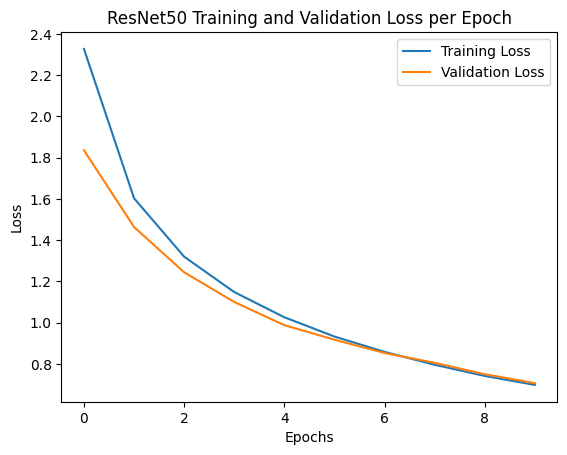

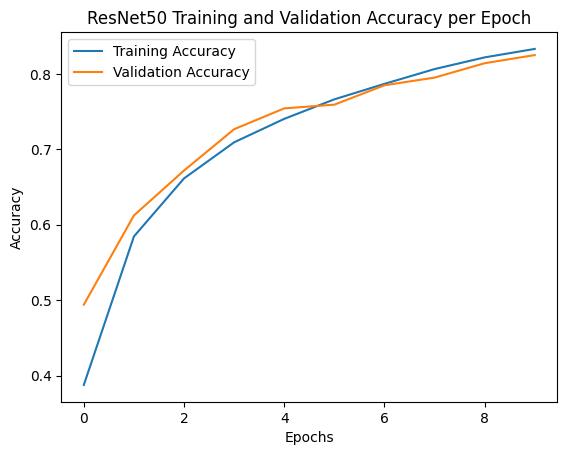

In [17]:
history_dict2 = history.history

plt.plot(history_dict2['loss'], label='Training Loss')
plt.plot(history_dict2['val_loss'], label='Validation Loss')
plt.title('ResNet50 Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history_dict2['accuracy'], label='Training Accuracy')
plt.plot(history_dict2['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 Training and Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
test_loss, test_accuracy = model.evaluate(test_tf_dataset, verbose=1)

y_true = []
y_pred = []
y_pred_probs = []

# Collect true labels and predictions
for images, labels in test_tf_dataset:
    y_true.extend(labels.numpy())
    predictions = model.predict(images, verbose=0)

    # Predicted class indices
    y_pred.extend(np.argmax(predictions, axis=-1))
    # Predicted probabilities
    y_pred_probs.extend(predictions)

# Calculate evaluation metrics
f1 = f1_score(y_true, y_pred, average='macro')
f2 = fbeta_score(y_true, y_pred, average='macro', beta=2)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

# Binarize labels for AUC calculation
num_classes = model.output_shape[-1]
y_true_binarized = label_binarize(y_true, classes=range(num_classes))

# Calculate Macro AUC
auc_score = roc_auc_score(y_true_binarized, np.array(y_pred_probs), average="macro", multi_class="ovr")

# Print the metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f'F1 Score (Macro Average): {f1:.4f}')
print(f'F2 Score (Macro Average): {f2:.4f}')
print(f'Precision (Macro Average): {precision:.4f}')
print(f'Recall (Macro Average): {recall:.4f}')
print(f'AUC (Macro Average): {auc_score:.4f}')

# Calculate and store ROC curve data for future plotting
resnet50_auc = []

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], np.array(y_pred_probs)[:, i])
    roc_auc = auc(fpr, tpr)
    resnet50_auc.append({
        "class": i,
        "fpr": fpr,
        "tpr": tpr,
        "auc": roc_auc
    })

338/338 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.8249 - loss: 0.7122
Test Accuracy: 0.8275
Test Loss: 0.7056
F1 Score (Macro Average): 0.8286
F2 Score (Macro Average): 0.8256
Precision (Macro Average): 0.8474
Recall (Macro Average): 0.8267
AUC (Macro Average): 0.9916


## Finetuning GoogleNet

In [19]:
dataset = load_dataset("pain/ArASL_Database_Grayscale")
train_df = dataset["train"].to_pandas()

from sklearn.model_selection import train_test_split
train_data, temp_data = train_test_split(train_df, test_size=0.4, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

labels = dataset["train"].features["label"].names
label_mapping = {i: label for i, label in enumerate(labels)}
num_classes = len(label_mapping)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, label_mapping, transform=None):
        self.dataframe = dataframe
        self.label_mapping = label_mapping
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_bytes = self.dataframe.iloc[idx]["image"]["bytes"]
        image = Image.open(io.BytesIO(img_bytes)).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.dataframe.iloc[idx]["label"]
        label = torch.tensor(label, dtype=torch.long)
        return image, label

# data loaders
train_dataset = CustomImageDataset(train_data, label_mapping, transform=transform)
val_dataset = CustomImageDataset(val_data, label_mapping, transform=transform)
test_dataset = CustomImageDataset(test_data, label_mapping, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [20]:
# Load GoogLeNet model and modify final layer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

googlenet = models.googlenet(pretrained=True)
googlenet.fc = nn.Linear(googlenet.fc.in_features, num_classes)
googlenet.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(googlenet.parameters(), lr=1e-4)

def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return running_loss / len(dataloader.dataset), accuracy

def validate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return running_loss / len(dataloader.dataset), accuracy


Batch [0], Loss: 3.5434
Batch [100], Loss: 1.9186
Batch [200], Loss: 0.6576
Batch [300], Loss: 0.3603
Batch [400], Loss: 0.2700
Batch [500], Loss: 0.1321
Batch [600], Loss: 0.1484
Batch [700], Loss: 0.2735
Batch [800], Loss: 0.0511
Batch [900], Loss: 0.2382
Batch [1000], Loss: 0.0600
Epoch [1/1]
Train Loss: 0.5559, Train Acc: 89.17%
Val Loss: 0.0414, Val Acc: 99.09%
Model saved as 'googlenet_model.pth'


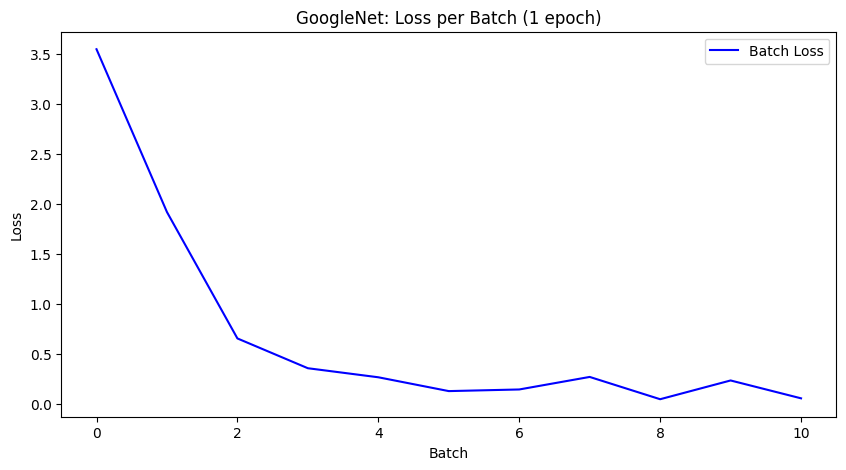

In [22]:
batch_losses = []

def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_index, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        if batch_index % 100 == 0:
            batch_losses.append(loss.item())
            print(f'Batch [{batch_index}], Loss: {loss.item():.4f}')

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return running_loss / len(dataloader.dataset), accuracy

# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    train_loss, train_acc = train(googlenet, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(googlenet, val_loader, criterion)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(googlenet.state_dict(), 'googlenet_model.pth')
print("Model saved as 'googlenet_model.pth'")

plt.figure(figsize=(10, 5))
plt.plot(batch_losses, label='Batch Loss', color='blue')
plt.title('GoogleNet: Loss per Batch (1 epoch)')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [23]:
def test(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    y_pred_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_pred_probs.extend(outputs.cpu().numpy())

    test_loss = running_loss / len(dataloader.dataset)
    accuracy = 100. * correct / total

    f1 = f1_score(y_true, y_pred, average='macro')
    f2 = fbeta_score(y_true, y_pred, average='macro', beta=2)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    num_classes = outputs.shape[1]
    y_true_binarized = label_binarize(y_true, classes=range(num_classes))
    y_pred_probs = np.array(y_pred_probs)

    auc_score = roc_auc_score(y_true_binarized, y_pred_probs, average="macro", multi_class="ovr")

    GoogleNet_auc = []

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        GoogleNet_auc.append({
            "class": i,
            "fpr": fpr,
            "tpr": tpr,
            "auc": roc_auc
        })

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'F1 Score (Macro Average): {f1:.4f}')
    print(f'F2 Score (Macro Average): {f2:.4f}')
    print(f'Precision (Macro Average): {precision:.4f}')
    print(f'Recall (Macro Average): {recall:.4f}')
    print(f'AUC (Macro Average): {auc_score:.4f}')

    return test_loss, accuracy, f1, f2, precision, recall, auc_score, GoogleNet_auc

test_loss, test_accuracy, test_f1, test_f2, precision, recall, auc_score, GoogleNet_auc = test(googlenet, test_loader, criterion)

Test Loss: 0.0492
Test Accuracy: 98.99%
F1 Score (Macro Average): 0.9900
F2 Score (Macro Average): 0.9900
Precision (Macro Average): 0.9899
Recall (Macro Average): 0.9901
AUC (Macro Average): 0.9995


## Finetuning a Vision Transformer

In [24]:
num_classes = len(label_mapping)
vit_model = models.vit_b_16(weights='DEFAULT')

vit_model.heads = nn.Linear(vit_model.heads[0].in_features, num_classes)

vit_model = vit_model.to(device)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_model.parameters(), lr=1e-4)

def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return running_loss / len(dataloader.dataset), accuracy

def validate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return running_loss / len(dataloader.dataset), accuracy


Batch [0], Loss: 3.5068
Batch [100], Loss: 0.2026
Batch [200], Loss: 0.1901
Batch [300], Loss: 0.2503
Batch [400], Loss: 0.0254
Batch [500], Loss: 0.2214
Batch [600], Loss: 0.2625
Batch [700], Loss: 0.0181
Batch [800], Loss: 0.0718
Batch [900], Loss: 0.2015
Batch [1000], Loss: 0.1581
Epoch [1/1]
Train Loss: 0.2576, Train Acc: 93.16%
Val Loss: 0.0881, Val Acc: 97.56%
Model saved as 'vit_model.pth'


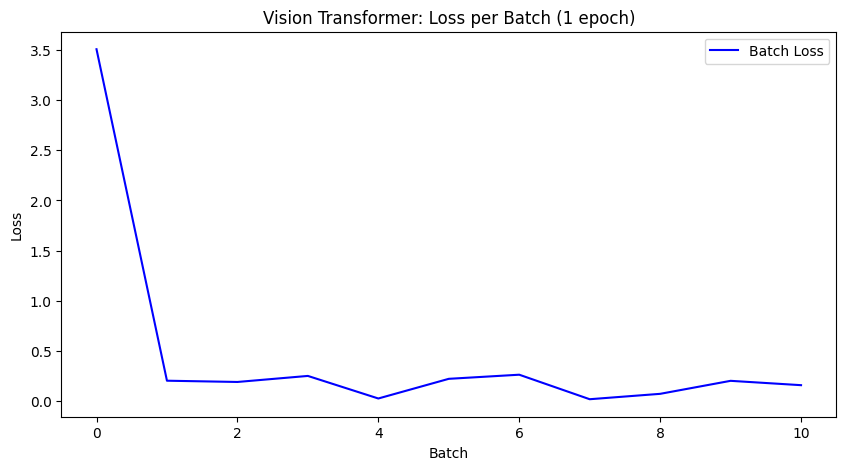

In [26]:
batch_losses = []

def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_index, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        if batch_index % 100 == 0:
            batch_losses.append(loss.item())
            print(f'Batch [{batch_index}], Loss: {loss.item():.4f}')

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return running_loss / len(dataloader.dataset), accuracy

# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    train_loss, train_acc = train(vit_model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(vit_model, val_loader, criterion)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(vit_model.state_dict(), 'vit_model.pth')
print("Model saved as 'vit_model.pth'")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(batch_losses, label='Batch Loss', color='blue')
plt.title('Vision Transformer: Loss per Batch (1 epoch)')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [27]:
def test(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    y_pred_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_pred_probs.extend(outputs.cpu().numpy())

    test_loss = running_loss / len(dataloader.dataset)
    accuracy = 100. * correct / total

    f1 = f1_score(y_true, y_pred, average='macro')
    f2 = fbeta_score(y_true, y_pred, average='macro', beta=2)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    num_classes = outputs.shape[1]
    y_true_binarized = label_binarize(y_true, classes=range(num_classes))
    y_pred_probs = np.array(y_pred_probs)

    auc_score = roc_auc_score(y_true_binarized, y_pred_probs, average="macro", multi_class="ovr")

    ViT_auc = []

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        ViT_auc.append({
            "class": i,
            "fpr": fpr,
            "tpr": tpr,
            "auc": roc_auc
        })

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'F1 Score (Macro Average): {f1:.4f}')
    print(f'F2 Score (Macro Average): {f2:.4f}')
    print(f'Precision (Macro Average): {precision:.4f}')
    print(f'Recall (Macro Average): {recall:.4f}')
    print(f'AUC (Macro Average): {auc_score:.4f}')

    return test_loss, accuracy, f1, f2, precision, recall, auc_score, ViT_auc

test_loss, test_accuracy, test_f1, test_f2, precision, recall, auc_score, ViT_auc = test(vit_model, test_loader, criterion)


Test Loss: 0.1022
Test Accuracy: 96.98%
F1 Score (Macro Average): 0.9701
F2 Score (Macro Average): 0.9699
Precision (Macro Average): 0.9712
Recall (Macro Average): 0.9700
AUC (Macro Average): 0.9996


## Implementing (Multi View Transformer Network) MVTN with a pretrained ResNet18 feature extractor

In [28]:
dataset = load_dataset("pain/ArASL_Database_Grayscale")
train_df = dataset["train"].to_pandas()

from sklearn.model_selection import train_test_split
train_data, temp_data = train_test_split(train_df, test_size=0.4, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

labels = dataset["train"].features["label"].names
label_mapping = {i: label for i, label in enumerate(labels)}
num_classes = len(label_mapping)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, label_mapping, transform=None):
        self.dataframe = dataframe
        self.label_mapping = label_mapping
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_bytes = self.dataframe.iloc[idx]["image"]["bytes"]
        image = Image.open(io.BytesIO(img_bytes)).convert("L")

        if self.transform:
            image = self.transform(image)

        label = self.dataframe.iloc[idx]["label"]
        label = torch.tensor(label, dtype=torch.long)
        return image, label


# data loaders
train_dataset = CustomImageDataset(train_data, label_mapping, transform=transform)
val_dataset = CustomImageDataset(val_data, label_mapping, transform=transform)
test_dataset = CustomImageDataset(test_data, label_mapping, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [29]:
class TransformerStage(nn.Module):
    def __init__(self, embed_dim_in, embed_dim_out, num_heads, depth, mlp_ratio=4.0, dropout=0.1):
        super(TransformerStage, self).__init__()
        self.layers = nn.ModuleList()
        for _ in range(depth):
            self.layers.append(
                nn.ModuleDict({
                    'norm1': nn.LayerNorm(embed_dim_in),
                    'attn': nn.MultiheadAttention(embed_dim_in, num_heads, dropout=dropout),
                    'norm2': nn.LayerNorm(embed_dim_in),
                    'mlp': nn.Sequential(
                        nn.Linear(embed_dim_in, int(embed_dim_in * mlp_ratio)),
                        nn.GELU(),
                        nn.Dropout(dropout),
                        nn.Linear(int(embed_dim_in * mlp_ratio), embed_dim_in),
                        nn.Dropout(dropout),
                    )
                })
            )
        # Linear projection for dimension reduction
        if embed_dim_in != embed_dim_out:
            self.linear_proj = nn.Linear(embed_dim_in, embed_dim_out)
        else:
            self.linear_proj = None

    def forward(self, x):
        x = x.transpose(0, 1)
        for layer in self.layers:
            # Self-attention
            x2 = layer['norm1'](x)
            attn_output, _ = layer['attn'](x2, x2, x2)
            x = x + attn_output
            # MLP
            x2 = layer['norm2'](x)
            x = x + layer['mlp'](x2)
        x = x.transpose(0, 1)
        if self.linear_proj is not None:
            x = self.linear_proj(x)
        return x

class MVTN(nn.Module):
    def __init__(self, num_classes):
        super(MVTN, self).__init__()
        # Feature extraction backbone
        resnet = models.resnet18(pretrained=True)
        # Adjust the first conv layer to accept 1 channel
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])

        # Transformer parameters
        embed_dims = [512, 256, 128]
        num_heads = [8, 4, 2]
        depths = [1, 1, 1]

        self.transformer_stages = nn.ModuleList()
        for i in range(len(depths)):
            self.transformer_stages.append(
                TransformerStage(
                    embed_dim_in=embed_dims[i],
                    embed_dim_out=embed_dims[i+1] if i+1 < len(embed_dims) else embed_dims[i],
                    num_heads=num_heads[i],
                    depth=depths[i]
                )
            )

        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dims[-1]),
            nn.Linear(embed_dims[-1], num_classes)
        )

    def forward(self, x):
        # Backbone feature extraction
        x = self.backbone(x)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)

        # Multiscale transformer
        for stage in self.transformer_stages:
            x = stage(x)

        # Global average pooling over sequence
        x = x.mean(dim=1)

        # Classification
        x = self.classifier(x)
        return x

class BasicBlock(nn.Module):
    expansion = 1  # For ResNet-18

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # Define convolutional layers and batch normalization
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.downsample = None
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion),
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


In [30]:
custom_pretrained_model = MVTN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_pretrained_model.parameters(), lr=1e-4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_pretrained_model.parameters(), lr=1e-4)

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return running_loss / len(dataloader.dataset), accuracy

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return running_loss / len(dataloader.dataset), accuracy

Batch [0], Loss: 3.6174
Batch [100], Loss: 0.8001
Batch [200], Loss: 0.2990
Batch [300], Loss: 0.2239
Batch [400], Loss: 0.2711
Batch [500], Loss: 0.3379
Batch [600], Loss: 0.1536
Batch [700], Loss: 0.3489
Batch [800], Loss: 0.0602
Batch [900], Loss: 0.1474
Batch [1000], Loss: 0.0474
Epoch [1/1]
Train Loss: 0.3838, Train Acc: 92.17%
Val Loss: 0.1008, Val Acc: 97.95%
Model saved as 'custom_pretrained_model.pth'


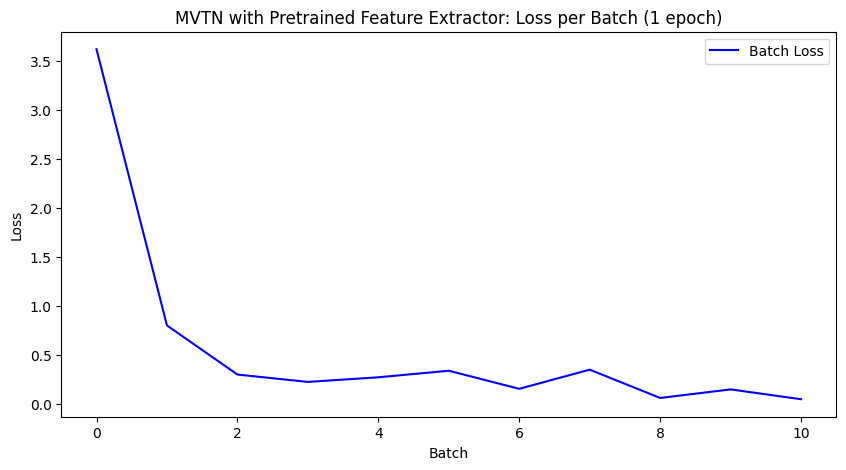

In [32]:
batch_losses = []

def train_with_batches(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_index, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        if batch_index % 100 == 0:
            batch_losses.append(loss.item())
            print(f'Batch [{batch_index}], Loss: {loss.item():.4f}')

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return running_loss / len(dataloader.dataset), accuracy

# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    train_loss, train_acc = train_with_batches(custom_pretrained_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(custom_pretrained_model, val_loader, criterion, device)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(custom_pretrained_model.state_dict(), 'custom_pretrained_model.pth')
print("Model saved as 'custom_pretrained_model.pth'")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(batch_losses, label='Batch Loss', color='blue')
plt.title('MVTN with Pretrained Feature Extractor: Loss per Batch (1 epoch)')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [33]:
def test_custom_pretrained_model(model, dataloader, criterion, device, num_classes):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    y_pred_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_pred_probs.extend(outputs.cpu().numpy())

    test_loss = running_loss / len(dataloader.dataset)
    accuracy = 100. * correct / total
    f1 = f1_score(y_true, y_pred, average='macro')
    f2 = fbeta_score(y_true, y_pred, average='macro', beta=2)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    y_true_binarized = label_binarize(y_true, classes=range(num_classes))
    y_pred_probs = np.array(y_pred_probs)

    auc_score = roc_auc_score(y_true_binarized, y_pred_probs, average="macro", multi_class="ovr")

    custom_pretrained_auc = []
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        custom_pretrained_auc.append({
            "class": i,
            "fpr": fpr,
            "tpr": tpr,
            "auc": roc_auc
        })

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'F1 Score (Macro Average): {f1:.4f}')
    print(f'F2 Score (Macro Average): {f2:.4f}')
    print(f'Precision (Macro Average): {precision:.4f}')
    print(f'Recall (Macro Average): {recall:.4f}')
    print(f'AUC (Macro Average): {auc_score:.4f}')

    return test_loss, accuracy, f1, f2, precision, recall, auc_score, custom_pretrained_auc

test_loss, test_accuracy, test_f1, test_f2, precision, recall, auc_score, custom_pretrained_auc = test_custom_pretrained_model(
    custom_pretrained_model, test_loader, criterion, device, num_classes
)

Test Loss: 0.1119
Test Accuracy: 97.65%
F1 Score (Macro Average): 0.9773
F2 Score (Macro Average): 0.9769
Precision (Macro Average): 0.9787
Recall (Macro Average): 0.9767
AUC (Macro Average): 0.9991


## Implementing (Multi View Transformer Network) MVTN with a non-pretrained ResNet16 feature extractor

In [34]:
class CustomResNet(nn.Module):
    def __init__(self, block, layers, num_classes):
        super(CustomResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64,  layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        self._initialize_weights()

    def _make_layer(self, block, out_channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [35]:
def resnet18(num_classes):
    return CustomResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)


In [36]:
class TransformerStage(nn.Module):
    def __init__(self, embed_dim_in, embed_dim_out, num_heads, depth, mlp_ratio=4.0, dropout=0.1):
        super(TransformerStage, self).__init__()
        self.layers = nn.ModuleList()
        for _ in range(depth):
            self.layers.append(
                nn.ModuleDict({
                    'norm1': nn.LayerNorm(embed_dim_in),
                    'attn': nn.MultiheadAttention(embed_dim_in, num_heads, dropout=dropout),
                    'norm2': nn.LayerNorm(embed_dim_in),
                    'mlp': nn.Sequential(
                        nn.Linear(embed_dim_in, int(embed_dim_in * mlp_ratio)),
                        nn.GELU(),
                        nn.Dropout(dropout),
                        nn.Linear(int(embed_dim_in * mlp_ratio), embed_dim_in),
                        nn.Dropout(dropout),
                    )
                })
            )
        # Linear projection for dimension reduction
        if embed_dim_in != embed_dim_out:
            self.linear_proj = nn.Linear(embed_dim_in, embed_dim_out)
        else:
            self.linear_proj = None

    def forward(self, x):
        x = x.transpose(0, 1)
        for layer in self.layers:
            # Self-attention
            x2 = layer['norm1'](x)
            attn_output, _ = layer['attn'](x2, x2, x2)
            x = x + attn_output
            # MLP
            x2 = layer['norm2'](x)
            x = x + layer['mlp'](x2)
        x = x.transpose(0, 1)
        if self.linear_proj is not None:
            x = self.linear_proj(x)
        return x

class MVTN(nn.Module):
    def __init__(self, num_classes):
        super(MVTN, self).__init__()
        # Backbone: Custom ResNet-18
        resnet = resnet18(num_classes=num_classes)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])

        # Transformer parameters
        embed_dims = [512, 256, 128]
        num_heads = [8, 4, 2]
        depths = [1, 1, 1]

        self.transformer_stages = nn.ModuleList()
        for i in range(len(depths)):
            self.transformer_stages.append(
                TransformerStage(
                    embed_dim_in=embed_dims[i],
                    embed_dim_out=embed_dims[i+1] if i+1 < len(embed_dims) else embed_dims[i],
                    num_heads=num_heads[i],
                    depth=depths[i]
                )
            )

        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dims[-1]),
            nn.Linear(embed_dims[-1], num_classes)
        )

    def forward(self, x):
        # Backbone feature extraction
        x = self.backbone(x)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        # Multiscale transformer
        for stage in self.transformer_stages:
            x = stage(x)

        # Global average pooling over sequence
        x = x.mean(dim=1)

        # Classification
        x = self.classifier(x)
        return x


In [37]:
custom_model = MVTN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_model.parameters(), lr=1e-4)

Batch [0], Loss: 3.6739
Batch [100], Loss: 2.1565
Batch [200], Loss: 1.2756
Batch [300], Loss: 0.7435
Batch [400], Loss: 0.6324
Batch [500], Loss: 0.7595
Batch [600], Loss: 0.3624
Batch [700], Loss: 0.0982
Batch [800], Loss: 0.1405
Batch [900], Loss: 0.2469
Batch [1000], Loss: 0.1094
Epoch [1/1]
Train Loss: 0.8574, Train Acc: 77.68%
Val Loss: 0.3169, Val Acc: 91.45%
Model saved as 'custom_model.pth'


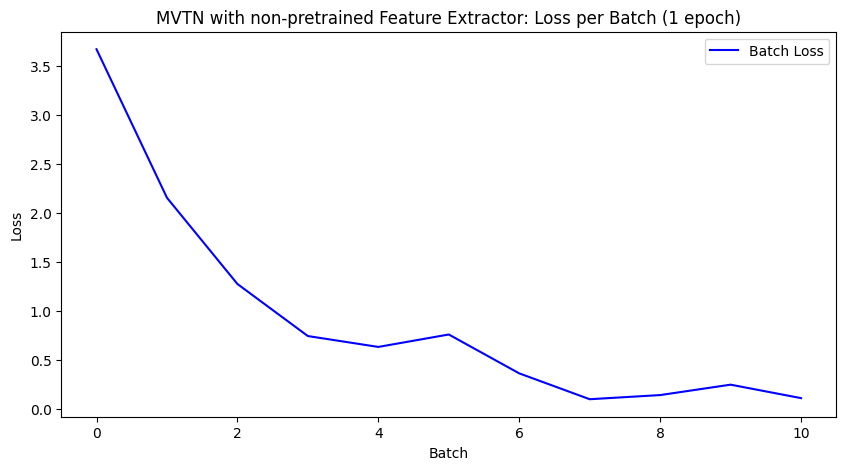

In [38]:
batch_losses = []

num_epochs = 1
for epoch in range(num_epochs):
    train_loss, train_acc = train_with_batches(custom_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(custom_model, val_loader, criterion, device)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(custom_model.state_dict(), 'custom_model.pth')
print("Model saved as 'custom_model.pth'")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(batch_losses, label='Batch Loss', color='blue')
plt.title('MVTN with non-pretrained Feature Extractor: Loss per Batch (1 epoch)')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [39]:
custom_model.to(device)

test_loss, test_accuracy, test_f1, test_f2, precision, recall, auc_score, custom_auc = test_custom_pretrained_model(
    custom_model, test_loader, criterion, device, num_classes
)


Test Loss: 0.3272
Test Accuracy: 91.14%
F1 Score (Macro Average): 0.9034
F2 Score (Macro Average): 0.9032
Precision (Macro Average): 0.9354
Recall (Macro Average): 0.9069
AUC (Macro Average): 0.9974


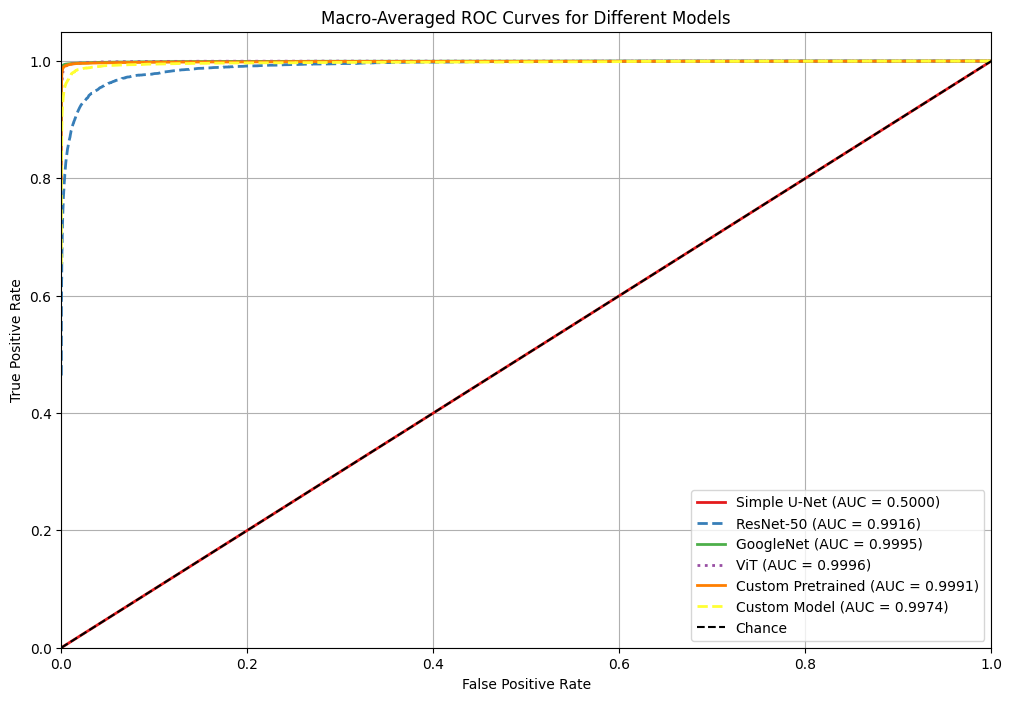

In [40]:
models_data = {
    "Simple U-Net": simple_unet_auc,
    "ResNet-50": resnet50_auc,
    "GoogleNet": GoogleNet_auc,
    "ViT": ViT_auc,
    "Custom Pretrained": custom_pretrained_auc,
    "Custom Model": custom_auc
}

colors = plt.cm.Set1.colors
line_styles = ['-', '--', 'solid', ':', '-', '--']
line_widths = [2, 2, 2, 2, 2, 2]
plt.figure(figsize=(12, 8))

for (model_name, model_auc_data), color, style, lw in zip(models_data.items(), colors, line_styles, line_widths):
    all_fpr = np.unique(np.concatenate([data['fpr'] for data in model_auc_data]))
    mean_tpr = np.zeros_like(all_fpr)

    for data in model_auc_data:
        mean_tpr += np.interp(all_fpr, data['fpr'], data['tpr'])

    mean_tpr /= len(model_auc_data)
    model_auc = auc(all_fpr, mean_tpr)

    plt.plot(all_fpr, mean_tpr, color=color, linestyle=style, linewidth=lw, label=f'{model_name} (AUC = {model_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-Averaged ROC Curves for Different Models')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
